load data and import classes

In [195]:
from modules.util import load_data, load_result_df
from modules.graphutil import generate_row
from modules.GCN import load_model, generate_output
import torch 
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
dataset, data, G, nodes, ddict = load_data('cora')
model = load_model('GCN3.pth', dataset)
model.eval()

rand = load_result_df(r'data/finalreport.csv')
greedy = pd.read_csv(r'data/finalreportgreedy.csv', index_col= 0)
benchmark = pd.read_csv(r'data/benchmark.csv', index_col= 0)


get benchmark data

In [196]:
from torcheval.metrics.functional import multiclass_f1_score
from collections import Counter

h = model(dataset.data.x, dataset.data.edge_index)
out = h.argmax(dim = 1)

f1_macro = multiclass_f1_score(out[data.test_mask], data.y[data.test_mask], 
                        num_classes=7, average = 'macro').item()
f_bench = multiclass_f1_score(out[data.test_mask], data.y[data.test_mask], 
                        num_classes=7, average = None).numpy()
f_bench = list(f_bench) + [f1_macro]


def labelingstats(out, data):
    correct_nodes = (out[data.test_mask] == data.y[data.test_mask]).nonzero().squeeze().flatten().numpy()
    mis_nodes = (out[data.test_mask] != data.y[data.test_mask]).nonzero().squeeze().flatten().numpy()

    TP = [x[1] for x in sorted(Counter((data.y[data.test_mask])[correct_nodes].flatten().numpy()).items())]
    FN = [x[1] for x in sorted(Counter((data.y[data.test_mask])[mis_nodes].flatten().numpy()).items())]

    FP = [x[1] for x in sorted(Counter(out[data.test_mask][mis_nodes].flatten().numpy()).items())]
    
    return TP, FP, FN

TP, FP, FN = labelingstats(out, dataset.data)

In [197]:
lc = Counter(dataset.data.y[dataset.data.test_mask].numpy())
labelcount = dict(lc)
testcount = [x[1] for x in sorted(labelcount.items())]
def divlist(list1, list2):
    return [a / b for a, b in zip(list1, list2)]

In [198]:
rand['Budget'] = rand.AddRatio + rand.RemoveRatio
rand = rand[rand.Budget <= 0.20] 
greedy = greedy[greedy.Budget.isin([0.05, 0.1, 0.20])] 
df_hp = pd.DataFrame(columns = ['Budget', 'PerturbType', 'PerturbedHomophily'])
df_hp = pd.concat([df_hp, rand[['Budget', 'PerturbType', 'PerturbedHomophily']], greedy[['Budget', 'PerturbType', 'PerturbedHomophily']]], ignore_index=True)
df_hp['dhomophily'] = df_hp.PerturbedHomophily - 0.8041

In [199]:
def makelegend(ax):
    handles, labels = ax.get_legend_handles_labels()  # Get handles and labels from the plot
    label_dict = {'add' : 'Add', 
            'remove' : 'Delete', 
            'addremove' : 'Add/Delete',
            'greedy' : 'Greedy',
            'RandomBenchmark':'Random Benchmark'}  # Label dictionary to map original labels to custom labels
    new_labels = [label_dict.get(label, label) for label in labels]  # Map labels to custom labels using the dictionary
    ax.legend(handles, new_labels, fontsize = 'small', ncol = 1)

    
def add_grid(ax):
    ax.grid(); 
    ax.set_axisbelow(True);


hue_colors = {
        'greedy' : 'tab:red', 
        'add' : 'tab:blue', 
            'remove' : 'tab:green', 
            'addremove' : 'tab:orange',
            'RandomBenchmark' : 'tab:pink', 
            } 
rand_order = ['add', 'addremove', 'remove']
greedy_order = ['greedy', 'RandomBenchmark']



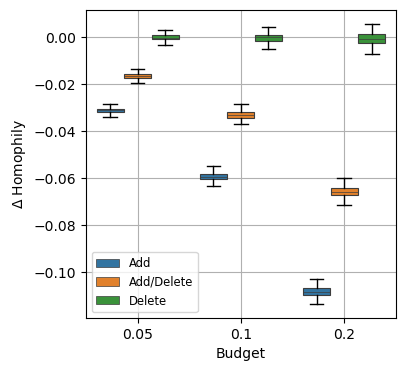

In [200]:
boxprops = {
    'boxprops':{'linewidth' : 0.8},
    'medianprops':{'linewidth' : 0.5},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
fig, ax = plt.subplots(figsize=(4, 4))

sns.boxplot(data=df_hp, x= 'Budget', y= 'dhomophily', hue = 'PerturbType', \
            showfliers = False, hue_order = rand_order, \
                palette = hue_colors,linewidth= 1, **boxprops)
makelegend(ax)
add_grid(ax)
plt.xlabel('Budget')
plt.ylabel(r'$\Delta$ Homophily')
plt.show()

In [201]:
df_hp[(df_hp['Budget'].isin([0.05,0.10, 0.20])) & (df_hp['PerturbType'] == 'remove')].groupby(by = [ 'Budget', 'PerturbType']).mean()

,,PerturbedHomophily,dhomophily
Budget,PerturbType,,
0.05,remove,0.804035,-0.000065
0.10,remove,0.803903,-0.000197
0.20,remove,0.803517,-0.000583


In [202]:
cols = ['PerturbedTestFScores', 'TP', 'FN', 'FP']
for col in cols:
    if col in rand.columns:
        benchmark[col] = benchmark[col].apply(ast.literal_eval)
    if col in greedy.columns:
        greedy[col] = greedy[col].apply(ast.literal_eval)
    if col in rand.columns:
        rand[col] = rand[col].apply(ast.literal_eval)

In [203]:
rand.reset_index(drop = True, inplace= True)
greedy.reset_index(drop = True, inplace= True)

In [234]:
import pandas as pd

def create_greedy_df(random, greedy, val, bench, labelcount):
    n = len(random.loc[0, val])
    outg = pd.DataFrame();outr = pd.DataFrame()

    outg['AddCount'] = greedy.add_count
    outg['RemoveCount'] = greedy.remove_count
    outg['PerturbType'] = 'greedy'

    outr['AddCount'] = random.AddRatio
    outr['RemoveCount'] = random.RemoveRatio
    outr['PerturbType'] = 'RandomBenchmark'

    classes = [[] for _ in range(n)]

    for c in range(len(random)):
        for i in range(n):
            if val =='PerturbedTestFScores':
                classes[i].append(random.loc[c, val][i] - bench[i])
            else:
                classes[i].append((random.loc[c, val][i] - bench[i]) )
    for i, c in enumerate(classes):
        outr[i] = c
    
    classes = [[] for _ in range(n)]
    
    for c in range(len(greedy)):
        for i in range(n):
            if val =='PerturbedTestFScores':
                classes[i].append(greedy.loc[c, val][i] - bench[i])
            else:
                classes[i].append((greedy.loc[c, val][i] - bench[i]) )
                
    for i, c in enumerate(classes):
        outg[i] = c
    
    out = pd.concat([outg, outr], ignore_index=True)

    out = pd.melt(out, id_vars = ['AddCount', 'RemoveCount', 'PerturbType'], value_vars=range(n),
                    var_name='class', value_name=val)  
    
    out['Budget'] =round((( out['AddCount'] + out['RemoveCount']) / 5069), 2)

    return out

In [235]:
df_test = create_greedy_df(benchmark, greedy, 'PerturbedTestFScores', f_bench, labelcount)
df_test

,AddCount,RemoveCount,PerturbType,class,PerturbedTestFScores,Budget
0,201,52,greedy,0,-0.038645,0.05
1,189,64,greedy,0,-0.052431,0.05
2,358,148,greedy,0,-0.092631,0.10
3,191,62,greedy,0,-0.044045,0.05
4,202,51,greedy,0,-0.055025,0.05
...,...,...,...,...,...,...
752611,194,59,RandomBenchmark,7,-0.006537,0.05
752612,194,59,RandomBenchmark,7,0.002089,0.05
752613,194,59,RandomBenchmark,7,-0.002058,0.05
752614,194,59,RandomBenchmark,7,-0.007736,0.05


In [236]:
import pandas as pd

def create_df(random, greedy, val, bench, labelcount):
    n = len(random.loc[0, val])
    outg = pd.DataFrame();outr = pd.DataFrame()

    outg['Budget'] = greedy.Budget
    outg['PerturbType'] = greedy.PerturbType

    outr['Budget'] = random.AddRatio + random.RemoveRatio
    outr['PerturbType'] = random.PerturbType


    classes = [[] for _ in range(n)]

    for c in range(len(random)):
        for i in range(n):
            if val =='PerturbedTestFScores':
                classes[i].append(random.loc[c, val][i] - bench[i])
            else:
                classes[i].append((random.loc[c, val][i] - bench[i]))
    for i, c in enumerate(classes):
        outr[i] = c
    
    classes = [[] for _ in range(n)]
    
    for c in range(len(greedy)):
        for i in range(n):
            if val =='PerturbedTestFScores':
                classes[i].append(greedy.loc[c, val][i] - bench[i])
            else:
                classes[i].append((greedy.loc[c, val][i] - bench[i]))
                
    for i, c in enumerate(classes):
        outg[i] = c
    
    out = pd.concat([outg, outr], ignore_index=True)

    out = pd.melt(out, id_vars = ['Budget', 'PerturbType'], value_vars=range(n),
                    var_name='class', value_name=val)  
    return out

In [237]:
df_fscore = create_df(rand, greedy, 'PerturbedTestFScores', f_bench, testcount)
query = df_fscore.groupby(by = ['Budget', 'PerturbType', 'class']).mean().reset_index()
#query[(query['class'].isin([1,6]))]
query = query[(query['Budget'].isin([0.05, 0.20])) & (query['PerturbType'] == 'greedy')].sort_values(by = ['class', 'Budget', 'PerturbType']).reset_index()

for i in range(0,len(query)-1, 2):
    print(query.iloc[i+1]['PerturbedTestFScores'] /query.iloc[i]['PerturbedTestFScores'] )




2.849103923256529
3.244094458378095
3.2681287585655285
3.4506932406619346
3.040634711133085
3.204934757900407
3.0589218903439725
3.159548640391867


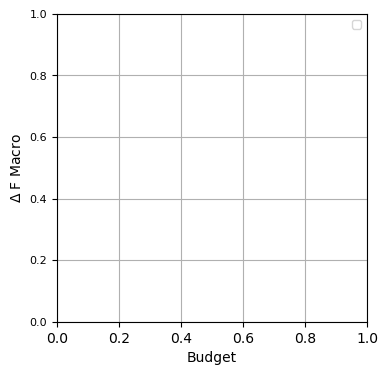

In [238]:
fig, ax = plt.subplots(figsize=(4, 4))


makelegend(ax)
add_grid(ax)
plt.xlabel('Budget')
plt.ylabel(r'$\Delta$ F Macro')
plt.tick_params(axis='y', labelsize=8)
plt.show()

In [239]:
df_test

,AddCount,RemoveCount,PerturbType,class,PerturbedTestFScores,Budget
0,201,52,greedy,0,-0.038645,0.05
1,189,64,greedy,0,-0.052431,0.05
2,358,148,greedy,0,-0.092631,0.10
3,191,62,greedy,0,-0.044045,0.05
4,202,51,greedy,0,-0.055025,0.05
...,...,...,...,...,...,...
752611,194,59,RandomBenchmark,7,-0.006537,0.05
752612,194,59,RandomBenchmark,7,0.002089,0.05
752613,194,59,RandomBenchmark,7,-0.002058,0.05
752614,194,59,RandomBenchmark,7,-0.007736,0.05


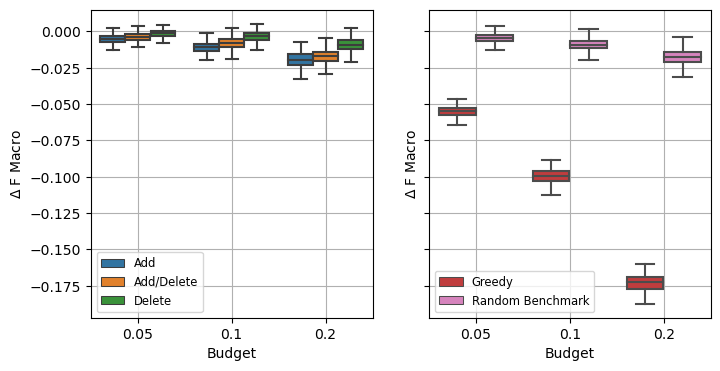

In [240]:
fig, ax = plt.subplots(1 , 2, figsize=(8, 4), sharey = True)
outr = df_fscore[df_fscore['class'] == 7]
outg = df_test[df_test['class'] == 7]

sns.boxplot(data=outg, x= 'Budget', y= 'PerturbedTestFScores', hue = 'PerturbType',\
             showfliers = False, hue_order=greedy_order, palette= hue_colors, ax = ax[1])

sns.boxplot(data=outr, x= 'Budget', y= 'PerturbedTestFScores', hue = 'PerturbType',\
             showfliers = False, hue_order = rand_order, palette= hue_colors, ax = ax[0])
makelegend(ax[0])
add_grid(ax[0])
makelegend(ax[1])
add_grid(ax[1])
plt.xlabel('Budget')
ax[0].set_ylabel(r'$\Delta$ F Macro')
ax[1].set_ylabel(r'$\Delta$ F Macro')
plt.tick_params(axis='y', labelsize=8)
plt.show()

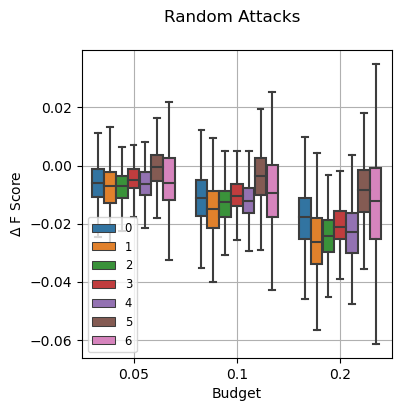

In [241]:
fig, ax = plt.subplots(figsize=(4, 4))
out = df_fscore[(df_fscore['class'] != 7) & (df_fscore['PerturbType'] == 'add')]
sns.boxplot(data=out, x= 'Budget', y= 'PerturbedTestFScores', hue = 'class', showfliers = False)
makelegend(ax)
add_grid(ax)
plt.xlabel('Budget')
plt.ylabel(r'$\Delta$ F Score')
plt.suptitle('Random Attacks')
plt.show()

In [242]:
out = df_fscore[(df_fscore['Budget'] == 0.05 ) & (df_fscore['class'] != 7) ]

sns.boxplot(data=out, x= 'class', y= 'PerturbedTestFScores', hue = 'PerturbType', showfliers = False, hue_order = ['add', 'addremove', 'remove', 'greedy'], ax = ax)


<AxesSubplot: xlabel='class', ylabel='PerturbedTestFScores'>

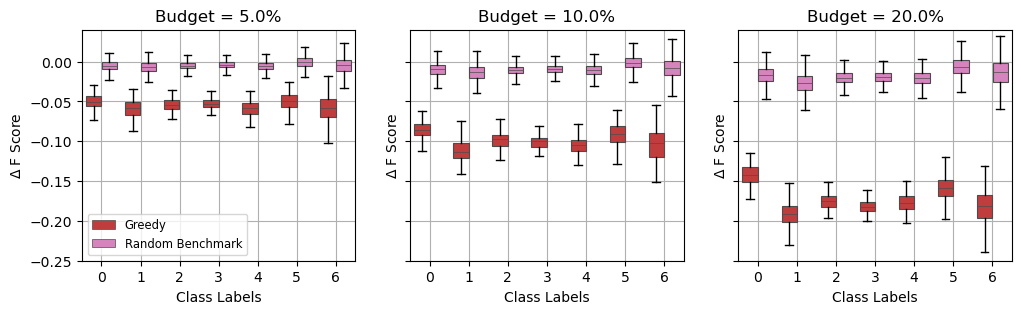

In [243]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3
                                    ), sharey= True)
budget = [0.05, 0.10, 0.20]
for i, b in enumerate(budget):
    out = df_test[(df_test['Budget'] == b ) & (df_test['class'] != 7) ]
    sns.boxplot(data=out, x= 'class', y= 'PerturbedTestFScores', hue = 'PerturbType', \
                showfliers = False, hue_order = greedy_order, \
                    linewidth = 1, **boxprops, ax = ax[i], palette = hue_colors)
    ax[i].set_xlabel('Class Labels')
    ax[i].legend().remove()
    add_grid(ax[i])
    ax[i].set_ylabel(r'$\Delta$ F Score')
    ax[i].set_title(f'Budget = {b*100}%')
makelegend(ax[0])
plt.ylim(-0.25, 0.04)
plt.show()

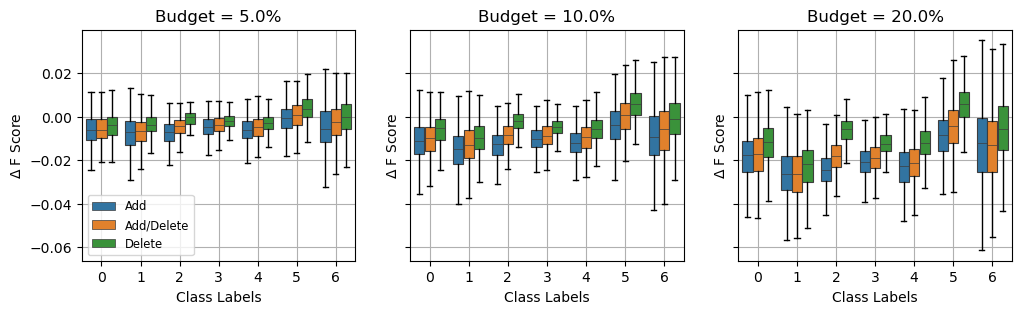

In [244]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3
                                    ), sharey= True)
budget = [0.05, 0.10, 0.20]
for i, b in enumerate(budget):
    out = df_fscore[(df_fscore['Budget'] == b ) & (df_fscore['class'] != 7) ]
    sns.boxplot(data=out, x= 'class', y= 'PerturbedTestFScores', hue = 'PerturbType', \
                showfliers = False, hue_order = ['add', 'addremove', 'remove'], \
                    linewidth = 1, **boxprops, ax = ax[i])
    ax[i].set_xlabel('Class Labels')
    ax[i].legend().remove()
    add_grid(ax[i])
    ax[i].set_ylabel(r'$\Delta$ F Score')
    ax[i].set_title(f'Budget = {b*100}%')
makelegend(ax[0])
plt.show()

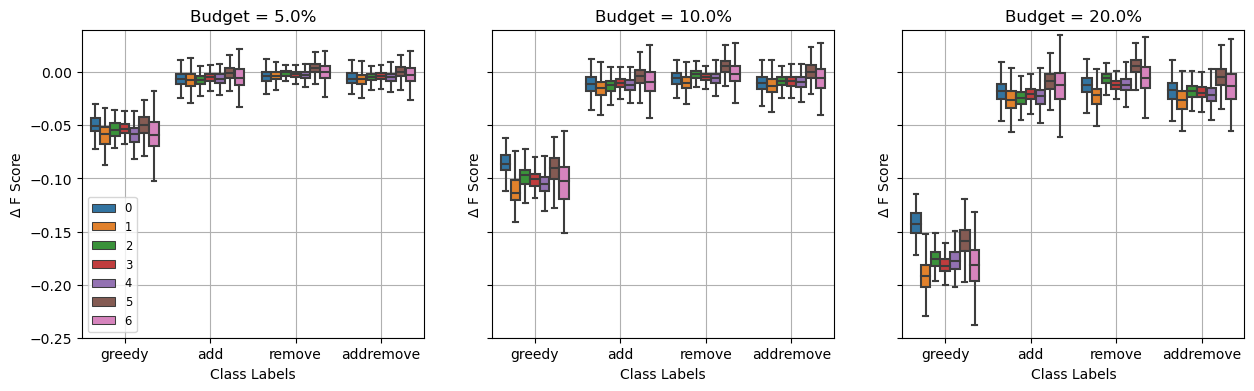

In [245]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey= True)
budget = [0.05, 0.10, 0.20]
for i, b in enumerate(budget):
    out = df_fscore[(df_fscore['Budget'] == b ) & (df_fscore['class'] != 7) ]
    sns.boxplot(data=out, x= 'PerturbType', y= 'PerturbedTestFScores', hue = 'class', showfliers = False, ax = ax[i])
    ax[i].set_xlabel('Class Labels')
    ax[i].legend().remove()
    add_grid(ax[i])
    ax[i].set_ylabel(r'$\Delta$ F Score')
    ax[i].set_title(f'Budget = {b*100}%')
makelegend(ax[0])
plt.ylim(-0.25, 0.04)
plt.show()

In [246]:
df_TP_g = create_greedy_df(benchmark, greedy, 'TP', TP, testcount)
df_TP_g = df_TP_g.groupby(by = ['Budget', 'class', 'PerturbType']).mean().reset_index()


In [247]:
df_TP = create_df(rand, greedy, 'TP', TP, testcount)
df_TP = df_TP.groupby(by = ['Budget', 'class', 'PerturbType']).mean().reset_index()


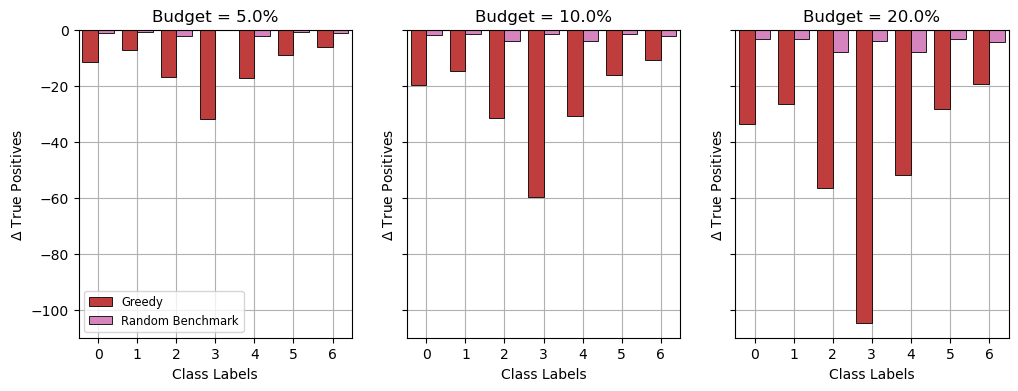

In [248]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey= True)
budget = [0.05, 0.10, 0.20]
for i, b in enumerate(budget):
    out = df_TP_g[(df_TP_g['Budget'] == b )]
    sns.barplot(data=out, x= 'class', y= 'TP', hue = 'PerturbType',\
                 hue_order =  greedy_order, palette = hue_colors, ax = ax[i], edgecolor = 'black', linewidth = 0.6)
    ax[i].set_xlabel('Class Labels')
    ax[i].legend().remove()
    add_grid(ax[i])
    ax[i].set_ylabel(r'$\Delta$ True Positives')
    ax[i].set_title(f'Budget = {b*100}%')
makelegend(ax[0])
plt.show()

for i in ['']:
    fig.savefig(f'/Users/ipeksahbazoglu/Desktop/dtp_norm_rand{i}.png')

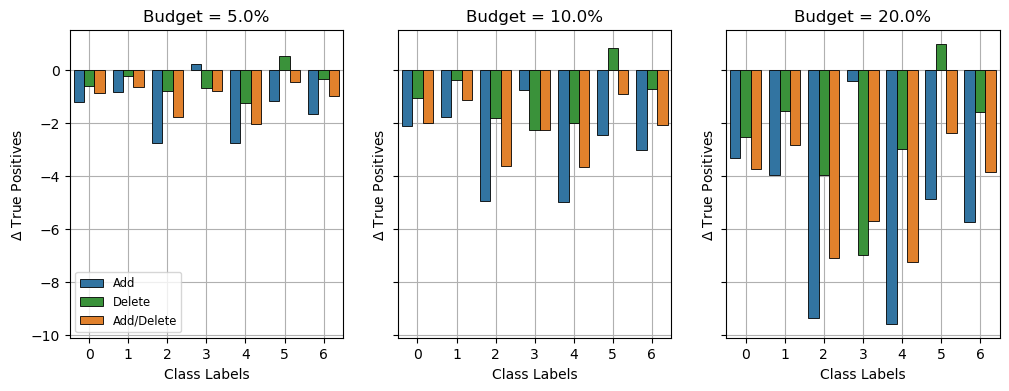

In [249]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey= True)
budget = [0.05, 0.10, 0.20]
for i, b in enumerate(budget):
    out = df_TP[(df_TP['Budget'] == b )]
    sns.barplot(data=out, x= 'class', y= 'TP', hue = 'PerturbType',\
                 hue_order =  ['add', 'remove', 'addremove'], palette = hue_colors, ax = ax[i], edgecolor = 'black', linewidth = 0.6)
    ax[i].set_xlabel('Class Labels')
    ax[i].legend().remove()
    add_grid(ax[i])
    ax[i].set_ylabel(r'$\Delta$ True Positives')
    ax[i].set_title(f'Budget = {b*100}%')
makelegend(ax[0])
plt.show()

for i in ['']:
    fig.savefig(f'/Users/ipeksahbazoglu/Desktop/dtp_norm_rand{i}.png')

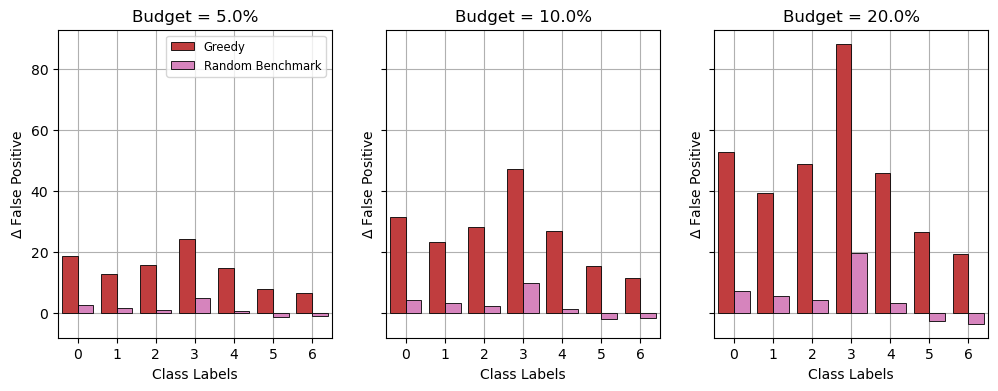

In [252]:
df_FP = create_greedy_df(benchmark, greedy, 'FP', FP, testcount)
df_FP = df_FP.groupby(by = ['Budget', 'class', 'PerturbType']).mean().reset_index()
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey= True)
budget = [0.05, 0.10, 0.20]
for i, b in enumerate(budget):
    out = df_FP[(df_FP['Budget'] == b )]
    sns.barplot(data=out, x= 'class', y= 'FP', hue = 'PerturbType',\
                hue_order = greedy_order, palette = hue_colors,
                edgecolor = 'black', linewidth = 0.6, ax = ax[i])
    ax[i].set_xlabel('Class Labels')
    ax[i].legend().remove()
    add_grid(ax[i])
    ax[i].set_ylabel(r'$\Delta$ False Positive')
    ax[i].set_title(f'Budget = {b*100}%')
makelegend(ax[0])
plt.show()

for i in ['']:
    fig.savefig(f'/Users/ipeksahbazoglu/Desktop/dfp_norm_rand{i}.png')

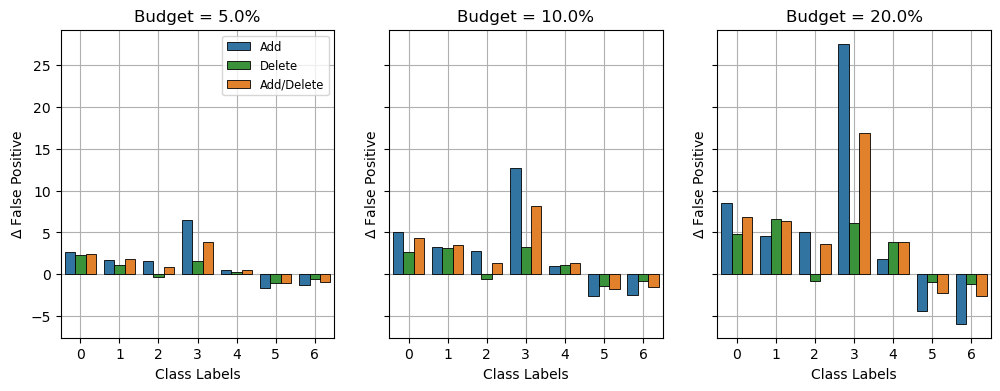

In [253]:
df_FP = create_df(rand, greedy, 'FP', FP, testcount)
df_FP = df_FP.groupby(by = ['Budget', 'class', 'PerturbType']).mean().reset_index()
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey= True)
budget = [0.05, 0.10, 0.20]
for i, b in enumerate(budget):
    out = df_FP[(df_FP['Budget'] == b )]
    sns.barplot(data=out, x= 'class', y= 'FP', hue = 'PerturbType',\
                hue_order = ['add', 'remove', 'addremove'], palette = hue_colors,
                edgecolor = 'black', linewidth = 0.6, ax = ax[i])
    ax[i].set_xlabel('Class Labels')
    ax[i].legend().remove()
    add_grid(ax[i])
    ax[i].set_ylabel(r'$\Delta$ False Positive')
    ax[i].set_title(f'Budget = {b*100}%')
makelegend(ax[0])
plt.show()

for i in ['']:
    fig.savefig(f'/Users/ipeksahbazoglu/Desktop/dfp_norm_rand{i}.png')

In [62]:
df_FP[(df_FP['Budget'].isin([0.05])) & (df_FP['PerturbType'] != 'addremove' )].sort_values(['Budget', 'FP'])

,Budget,class,PerturbType,FP
24,0.05,6,add,-0.014944
20,0.05,5,add,-0.007952
27,0.05,6,remove,-0.006433
23,0.05,5,remove,-0.005264
11,0.05,2,remove,-0.001161
19,0.05,4,remove,0.000891
16,0.05,4,add,0.001747
15,0.05,3,remove,0.002897
8,0.05,2,add,0.005185
7,0.05,1,remove,0.007672
